# Example 3.5: Monte Carlo simulation of stochastic time series with a given auto-spectral density
In this example, we will show procedures to make realisations of a stationary stochastic process with a given auto-spectral density. 

## Auto-spectral density

We start by defining the auto spectral density that we will consider in this example. This is a (one-sided!) spectrum used to describe wave elevations in the North Sea:

$$
S_X(\omega) = 
\alpha g^2  \omega^{-5}
\exp \left(- \dfrac{5}{4} \left( \dfrac{\omega_m}{\omega} \right)^{4} \right)
$$

Here, $g=9.81$, $\alpha=8.1 \cdot 10^{-3}$, and $\omega_m$ is a parameter that controls where the peak of the spectral density is located. We set $\omega_m=0.6$.

The auto-spectral density is defined and plotted below.

C:\Users\oyvinpet\AppData\Local\Temp\ipykernel_22976\2170385734.py:12: RuntimeWarning: divide by zero encountered in power
  Sx=alpha*g**2*omega**-5*np.exp(-5/4*(omega_m/omega)**4)
C:\Users\oyvinpet\AppData\Local\Temp\ipykernel_22976\2170385734.py:12: RuntimeWarning: divide by zero encountered in divide
  Sx=alpha*g**2*omega**-5*np.exp(-5/4*(omega_m/omega)**4)
C:\Users\oyvinpet\AppData\Local\Temp\ipykernel_22976\2170385734.py:12: RuntimeWarning: invalid value encountered in multiply
  Sx=alpha*g**2*omega**-5*np.exp(-5/4*(omega_m/omega)**4)


Text(0.5, 0, '$\\omega$')

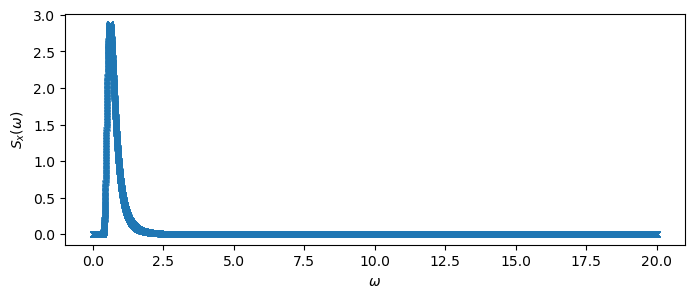

In [27]:
import numpy as np
from matplotlib import pyplot as plt
import time

omega = np.arange(0,20,0.001) # Frequency axis
N=len(omega)

g=9.81
alpha=8.1e-3
omega_m=0.6

Sx=alpha*g**2*omega**-5*np.exp(-5/4*(omega_m/omega)**4)
Sx[0]=0

plt.figure(figsize=(8,3))
plt.plot(omega,Sx,marker='x',markersize=5)
plt.ylabel(r'$S_x(\omega)$')
plt.xlabel(r'$\omega$')


## Method 1: Sum of cosine terms
The following formula can obtain realizations of the stochastic process.

$$x(t) = \sum_{k=0}^{N-1}  A_k \cos (\omega_kt + \phi_k) $$

$$A_k = \sqrt{2 S_x(\omega_k) \Delta \omega} $$

Here, $S_x(\omega_k)$ is the auto-spectral density of the process, and $\phi_k$ is random phase angles evenly distributed between $0$ and $2\pi$.

Spent time = 10310.429811477661


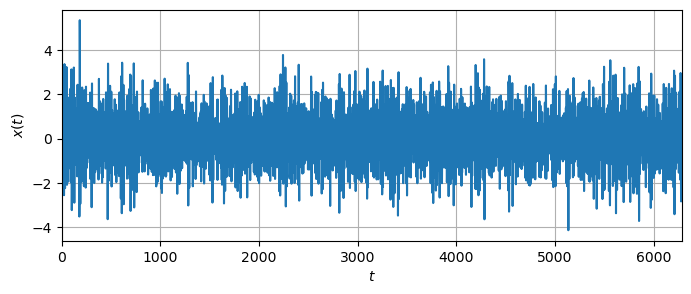

In [28]:
domega = omega[1]-omega[0] # Frequency spacing

T=2*np.pi/domega
dt=T/N

t0=time.time()
t = np.arange(0,T,dt) # Time vector
phi = np.random.rand(N)*2*np.pi # Random phase angles 

x = np.zeros_like(t) # Initialize the vector of x values
for k in range(N):
    Ak = (2*Sx[k]*domega)**0.5 #Amplitude
    x = x + Ak * np.cos(omega[k]*t+phi[k]) # Sum the contribution from each harmonic component
t1=time.time()

print('Spent time = ' + str((t1-t0)*1000))

plt.figure(figsize=(8,3))
plt.plot(t,x)
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')
plt.xlim(0,T)
plt.grid()


We observe that the realization indeed looks like a random process. Try changing the frequency spacing or the maximum in the $\omega$-axis, and see how that influences the time-domain properties of the simulated time series.

We can also plot the individual frequency components. 

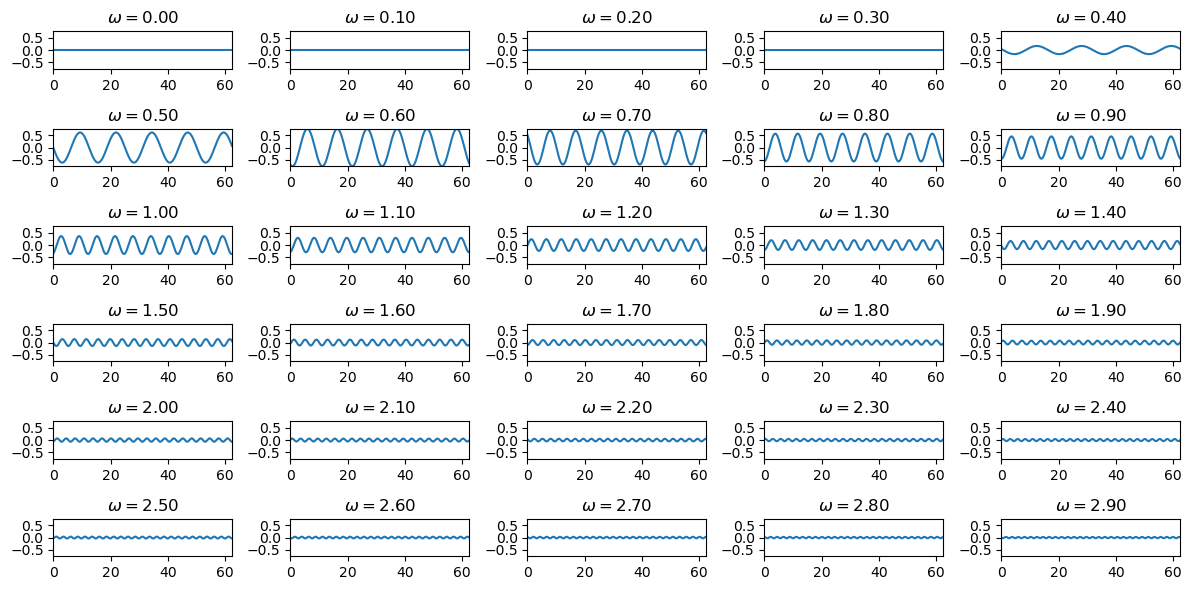

In [23]:
# Plot the 40 first harmonic contributions
fig, axs = plt.subplots(6, 5, figsize=(12, 6))

k=-1
for i in range(6):
    for j in range(5):
        k=k+1
        Ak = (2*Sx[k]*domega)**0.5
        axs[i,j].plot(t,Ak * np.cos(omega[k]*t+ phi[k]))
        axs[i,j].set_title('$\omega=$' + '{:.2f}'.format(omega[k]))

        axs[i,j].set_xlim(0,np.max(t))
        axs[i,j].set_ylim(np.max((2*Sx*domega)**0.5)*np.array([-1.0,1.0]))
        
plt.tight_layout()

The cosine waves with lowest frequencies contribute little since $S(\omega)$ has no energy here. The greatest contributions comes from $\omega \in [0.4,1]$ rad/s, where the wave energy is concentrated. Notice that all cosine waves also have different phase angles: some start with a peak at $t=0$, others start with a dip, and so on.

## Alternative 2: The inverse fast Fourier transform (IFFT)
It is also possible to use the IFFT to calculate the realizations of the stochastic process. This is a considerable advantage since this approach is much faster than the cosine-sum method shown above. We start by rewriting the cosine-sum expression slightly:

$$
\begin{align}
x(t) &= \sum_{k=0}^{N-1} A_k \cos(\omega_k t + \phi_k) \\
&= \Re \left(\sum_{k=0}^{N-1}  A_k e^{i (\omega_k t + \phi_k)} \right) \\
&= \Re \left(\sum_{k=0}^{N-1}  A_k e^{i \phi_k}e^{i \omega_k t}  \right)
\end{align}
$$

Here we recognize the inverse discrete Fourier transform, and we can define

$$x(t) = \Re \left(\text{IFFT} \left( A_k e^{i \phi_k} \right) \right)$$

The code below shows an example:


Spent time = 3.8192272186279297


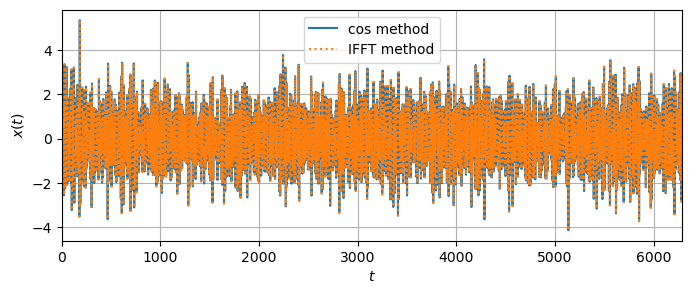

In [29]:



#phi = np.random.rand(N)*2*np.pi # Random phase angles 

t0=time.time()
c = (2*Sx*domega)**0.5*np.exp(1j*phi) # The complex amplitude including the phase angle
x_ifft = np.real(np.fft.ifft(c)*N) # The IFFT
t_ifft = np.linspace(0,2*np.pi/domega*(N-1)/N,N) # Time axis
t1=time.time()

print('Spent time = ' + str((t1-t0)*1000))

plt.figure(figsize=(8,3))
plt.plot(t,x,label= 'cos method')
plt.plot(t_ifft,x_ifft,label = 'IFFT method',linestyle=':')
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')
plt.xlim(0,T)
plt.grid()
plt.legend()


The figure above shows the realisation obtained by IFFT compared to the time series obtained by summing cosine terms. The time series are equal because the two methods are equal, and the same phase angles have been used to generate both. Try using different phase angles by running the cells one more time and investigating how realisations differ.